# Analysis of how much data shuffling affects learning curves

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path

import sklearn
import numpy as np
import pandas as pd
from scipy.stats import iqr
from glob import glob

from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

# Make all python scripts available in the path
sys.path.append('../')

import pp_utils
import lrn_crv_plot
%matplotlib inline

filepath = Path(os.getcwd())
print(filepath)

/vol/ml/apartin/projects/LearningCurves/notebooks


In [2]:
from fit import * # weighted_power_law, fit_weighted_pwr_law
import rpy2.robjects as robjects

In [3]:
def calc_gof(y, yfit):
    gof = {}
    rmse = sqrt( metrics.mean_squared_error(y, yfit) )
    mae = metrics.mean_absolute_error(y, yfit)
    gof['rmse'] = rmse
    gof['mae'] = mae
    return gof

In [4]:
# Set Y axis
def set_yticks_ap(ax, ylim=None):
    """ Adjust y ticks. """
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    if (ylim is None):
        ylim = ax.get_ylim()
    ylim_log = np.log2(ylim)
    ylabels_log = np.logspace(ylim_log[0], ylim_log[1], num=5, base=2)
    ylabels_log = np.around(ylabels_log, decimals=3)
    ax.set_yticks(ylabels_log)
    return ax

### Load results from runs

In [15]:
# src = 'gdsc'
src = 'top6'

# GDSC
if src == 'gdsc':
    base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/multi_seed_lgbm_100_trees'); model='lgbm'
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/nn_reg0_sub'); model='nn'
    
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/nn_reg0'); model='nn'
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/multi_seed_rf_100_trees'); model='rf'
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/nn_reg0_')

elif src == 'top6':
    base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/multi_seed_lgbm_100_trees'); model='lgbm'
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/nn_reg0'); model='nn'
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/multi_seed_rf_100_trees'); model='rf'
    
elif src == 'ctrp':
    pass
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_lgbm_100_trees')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_rf_100_trees')
    
elif src == 'top21':
    pass
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top21/multi_seed_lgbm_100_trees/trn.top21/split_on_cell/')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_lgbm_100_trees')
    
runs = glob(str(base_dir/'*'))

In [16]:
scores = []
# prf = 'id'
prf = 'run'

for i, r in enumerate(runs):
    # scr_tmp = pd.read_csv( Path(r)/'lrn_crv_scores.csv' )
    dpath = Path(r)/'lrn_crv_scores.csv'
    if not dpath.exists():
        continue
        
    scr_tmp = pd.read_csv( dpath )
    scr_tmp.rename(columns={'fold0': prf+str(i)}, inplace=True)
    if len(scores)==0:
        scores = scr_tmp
    else:
        scores = scores.merge(scr_tmp, on=['metric', 'tr_size', 'set'])
    scr_tmp['file'] = str(dpath)
        
run_col_names = [c for c in scores.columns if prf in c]

scores_mean   = scores[run_col_names].mean(axis=1)
scores_median = scores[run_col_names].median(axis=1)
scores_std    = scores[run_col_names].std(axis=1)
# scores_iqr    = iqr(scores.iloc[:, 6:].values, axis=0)

scores.insert(loc=3, column='mean', value=scores_mean)
scores.insert(loc=3, column='median', value=scores_median)
scores.insert(loc=3, column='std', value=scores_std)
print(len(np.unique(scores.tr_size)))

# display(scores[:2])
print('Training set sizes:', np.unique(scores.tr_size))

# scores_te = scores[(scores.metric=='mean_absolute_error') & (scores.set=='te')].reset_index(drop=True).iloc[:, :6]
scores_te = scores[(scores.metric=='mean_absolute_error') & (scores.set=='te')].reset_index(drop=True)

save = True
if save:
    scores.to_csv(base_dir/'all_seed_runs_scores.csv', index=False)
    scores_te.to_csv(base_dir/'scores.csv', index=False)

18
Training set sizes: [     2      4      8     16     32     64    128    256    512   1024
   2048   4096   8192  16384  32768  65536 131072 213015]


In [17]:
# (scr.iloc[0,6:] < 0.58)
# run_names = ['run0', 'run2', 'run3', 'run7', 'run8', 'run10', 'run13', 'run15', 'run17', 'run18']
# tmp = scores_te.iloc[:, 6:]
# scr = pd.concat([scores_te.iloc[:, :6], tmp[run_names]], axis=1)

In [18]:
# scores_te.T

In [19]:
# # scores_te[[c for c in scores_te.columns if c not in ['run9', 'run12', 'run16']]]
# tmp = scores_te[[c for c in scores_te.columns if c in ['file', 'run9', 'run12', 'run16']]]
# pd.concat([scores_te.iloc[:,:5], tmp], axis=1)

# LC all lin-lin

In [20]:
figsize = (6, 4.5)
metric_name = 'mean_absolute_error'
tr_set = 'te'

# shift_idx=0
# shift_idx=1
# shift_idx=2
# shift_idx=3

if src=='gdsc':
    shift_idx=2
elif src=='top6':
    shift_idx=2

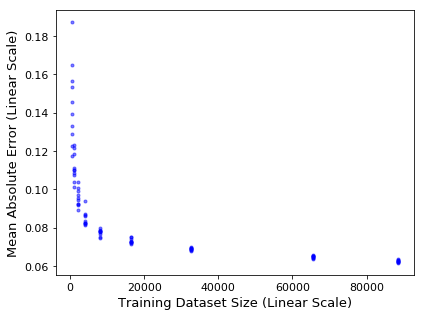

In [11]:
plot_args = {'tr_set': tr_set, 'metric_name': metric_name, 'figsize': figsize, 'xtick_scale': 'linear', 'ytick_scale': 'linear'}

ax = pp_utils.plot_lc_multi_runs( runs, shard_min_idx=shift_idx, **plot_args );

ax.tick_params(axis='both', labelsize=11)
ax.grid(False)

plt.tight_layout()
plt.savefig(base_dir/(f'{src}_{model}_all_runs_linlin.png'), dpi=200)

# LC all log-log

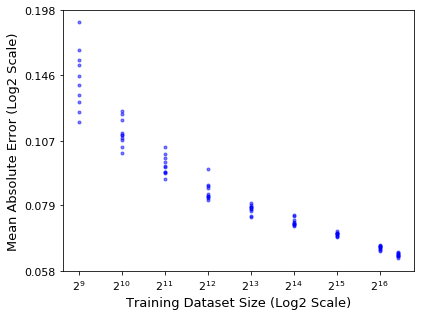

In [12]:
plot_args = {'tr_set': tr_set, 'metric_name': metric_name, 'figsize': figsize, 'xtick_scale': 'log2', 'ytick_scale': 'log2'}

ax = pp_utils.plot_lc_multi_runs( runs, shard_min_idx=shift_idx, **plot_args );

# print(ax.xaxis.get_major_locator())
# print(ax.yaxis.get_major_locator())
# print(ax.xaxis.get_major_formatter())
# print(ax.yaxis.get_major_formatter())

# General axes prms
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
ax.tick_params(axis='both', labelsize=11)

# Set X axis
xlim = ax.get_xlim()
# ax.set_xticks([2**i for i in range(2, 17)])
# ax.set_ylim([0.063, 0.195]) # GDSC GBDT

# Set Y axis
ax = set_yticks_ap(ax)

ax.grid(False)
plt.tight_layout()
plt.savefig(base_dir/(f'{src}_{model}_all_runs_loglog.png'), dpi=200)

In [13]:
# Fit data
# pp_utils.fit_lc_multi_runs(runs, metric_name=metric_name, tr_set='te',
#                              shard_min_idx=shard_min_idx, cv_folds=1,
#                              xtick_scale=xtick_scale, ytick_scale=ytick_scale)

In [14]:
# x, y = get_xy(Path(runs[2]), metric_name='mean_absolute_error', tr_set='te', shard_min_idx=0, cv_folds=1)
# ax = lrn_crv_plot.plot_lrn_crv_power_law(x=x, y=y, marker='.', alpha=0.7)

# LC of Median and STD across shuffles

In [21]:
plot_args = {'metric_name': metric_name, 'xtick_scale': 'log2', 'ytick_scale': 'log2', 'figsize': figsize}

# The previous two figures should help decide which shards to use
scr = scores_te[shift_idx:].reset_index(drop=True)
y_col_name = 'median'

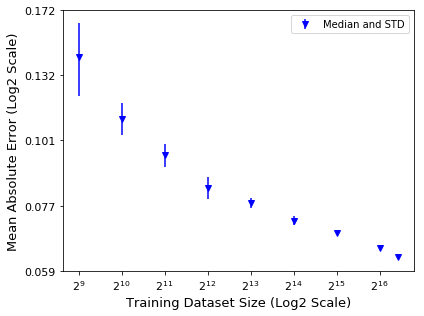

In [16]:
x = scr['tr_size'].values
y = scr[y_col_name].values
yerr = scr['std'].values

shard_min_id = 0
xf = x[shard_min_id:]
yf = y[shard_min_id:]

ax = None

ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=1,
                                   **plot_args, color='b', label='Median and STD');
# ---------------------
# General axes prms
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
ax.tick_params(axis='both', labelsize=11)

# Set X axis
xlim = ax.get_xlim()
# ax.set_xticks([2**i for i in range(2, 17)])

# Set Y axis
ax = set_yticks_ap(ax)

ax.legend(frameon=True, fontsize=10, loc='best');
ax.grid(False)
plt.tight_layout()
plt.savefig(base_dir/(f'{src}_{model}_avg_median_std.png'), dpi=200)

# Fig 1 (show learning trends of a learning curve)

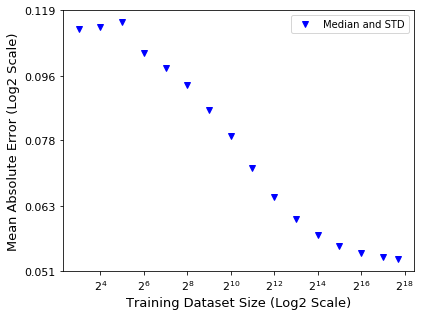

In [23]:
figsize = (6, 4.5)
# figsize = (10, 8)

# scale = 'linear'
scale = 'log2'
plot_args = {'metric_name': metric_name, 'xtick_scale': scale, 'ytick_scale': scale, 'figsize': figsize}

# The previous two figures should help decide which shards to use
scr = scores_te[shift_idx:].reset_index(drop=True)
y_col_name = 'median'

x = scr['tr_size']
y = scr[y_col_name]
yerr = scr['std']

shard_min_idx = 0
xf = x[shard_min_idx:]
yf = y[shard_min_idx:]

ax = None

ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y,
                                   ax=ax, ls='', marker='v', alpha=1,
                                   **plot_args, color='b', label='Median and STD')
# ---------------------
# General axes prms
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
ax.tick_params(axis='both', labelsize=11)

# Set X axis
xlim = ax.get_xlim()
# ax.set_xticks([2**i for i in range(2, 17)])

# Set Y axis
ax = set_yticks_ap(ax)

ax.legend(frameon=True, fontsize=10, loc='best');
ax.grid(False)
plt.tight_layout()
plt.savefig(base_dir/(f'{src}_{model}_fig1_{scale}.png'), dpi=200)

# Fit using all shards

GOF: {'rmse': 0.004562173474933628, 'mae': 0.0024449793625102947}


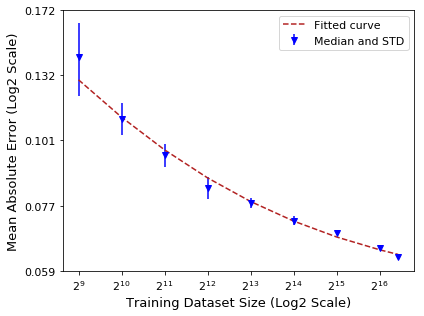

In [17]:
x = scr['tr_size'].values
y = scr[y_col_name].values
yerr = scr['std'].values

shard_min_id = 0
xf = x[shard_min_id:]
yf = y[shard_min_id:]
prms = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms)

ax = None

# Median values
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=1,
                                   **plot_args, color='b', label='Median and STD')

# Fit
ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=1,
                                   **plot_args, color='firebrick', label='Fitted curve')
gof = calc_gof(yf, yfit)
print('GOF:', gof)

# ---------------------
# General axes prms
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
ax.tick_params(axis='both', labelsize=11)

# Set X axis
xlim = ax.get_xlim()
# ax.set_xticks([2**i for i in range(2, 17)])

# Set Y axis
ax = set_yticks_ap(ax)

ax.legend(frameon=True, fontsize=11, loc='best');
ax.grid(False)
plt.tight_layout()
plt.savefig(base_dir/(f'{src}_{model}_fit_using_all_pnts.png'), dpi=200)

# Fit using subset of shards

GOF: {'rmse': 0.004562173474933628, 'mae': 0.0024449793625102947}


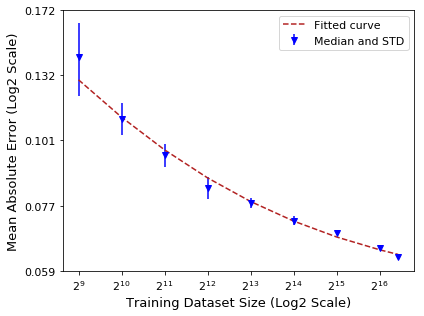

In [18]:
tot_pnts = len(x)
n_pnts_fit = 9 # Number of points to use for curve fitting starting from the largest size

x = scr['tr_size'].values
y = scr[y_col_name].values
yerr = scr['std'].values

shard_min_id = 0 if tot_pnts < n_pnts_fit else tot_pnts - n_pnts_fit

xf = x[shard_min_id:]
yf = y[shard_min_id:]
prms = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms)

ax = None

# Median values
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=1,
                                   **plot_args, color='b', label='Median and STD')

# Fit
ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=1,
                                   **plot_args, color='firebrick', label='Fitted curve')
gof = calc_gof(yf, yfit)
print('GOF:', gof)

# ---------------------
# General axes prms
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
ax.tick_params(axis='both', labelsize=11)

# Set X axis
xlim = ax.get_xlim()
# ax.set_xticks([2**i for i in range(2, 17)])

# Set Y axis
ax = set_yticks_ap(ax)

ax.legend(frameon=True, fontsize=11, loc='best');
ax.grid(False)
plt.tight_layout()
plt.savefig(base_dir/(f'{src}_{model}_fit_using_subset_pnts.png'), dpi=200)

# GOF (fit MAE) vs Number of LC fit points

The workflow is to go backwards. We fit a power-law after every time we compute score for consecutive (smaller) shard. Stop when quality of fit decreases.

tot_pnts 9


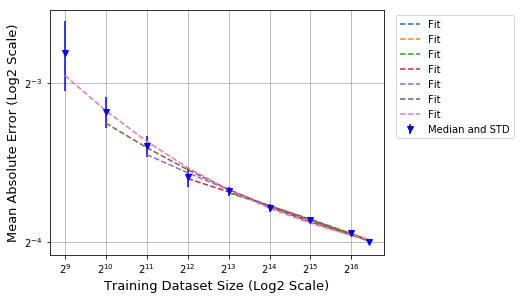

In [19]:
x = scr['tr_size'].values
y = scr[y_col_name].values
yerr = scr['std'].values

tot_pnts = len(x)
print('tot_pnts', tot_pnts)
min_pnts_fit = 3  # 3 points doesn't work
# min_pnts_fit = 4  # Min points to fit 
# max_pnts_fit = 9  # Min points to fit
max_pnts_fit = tot_pnts

p_arr = []
gof_arr = []
prm_arr = []
xmin = []

ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=1,
                                   **plot_args, color='b', label='Median and STD');

for n_pnts_fit in range(min_pnts_fit, max_pnts_fit+1):
    shard_min_idx = tot_pnts - n_pnts_fit
    
    xf = x[shard_min_idx:]
    yf = y[shard_min_idx:]
    prms = fit_params(xf, yf)
    yfit = biased_powerlaw(xf, **prms)
    
    gof = calc_gof(yf, yfit)
    
    ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                       ax=ax, ls='--', marker='', alpha=1,
                                       **plot_args, label='Fit');
    
    prm_arr.append(prms)
    gof_arr.append(gof)
    p_arr.append(n_pnts_fit)
    xmin.append(xf[0])

In [20]:
prm_df = pd.DataFrame(prm_arr)
gof_df = pd.DataFrame(gof_arr)
xmin_df = pd.DataFrame(xmin)
n_pnts_df = pd.DataFrame({'n_pnts': p_arr})
dd = pd.concat([n_pnts_df, xmin_df, gof_df, prm_df], axis=1)
dd = dd.sort_values('mae')
display(dd)

dd.to_csv(base_dir/f'{src}_{model}_fit_mae_vs_nfit_pnts.csv', index=False)

,n_pnts,0,mae,rmse,alpha,beta,gamma
0,3,32768,0.000191,0.000224,2.474275,-0.002562,-2.340233
1,4,16384,0.000244,0.000328,4.733613,-0.001204,-4.605992
3,6,4096,0.000355,0.000428,0.243442,-0.038583,-0.094136
2,5,8192,0.000372,0.000450,28.366421,-0.000215,-28.234071
4,7,2048,0.001025,0.001441,0.243584,-0.194511,0.036287
5,8,1024,0.001386,0.002128,0.446106,-0.295726,0.047614
6,9,512,0.002445,0.004562,0.922672,-0.400598,0.053522


X axis range: (2.7, 9.3)


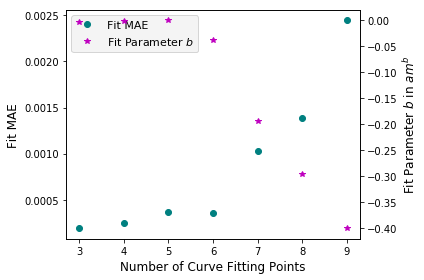

In [21]:
# plot_beta = False
plot_beta = True

fig, ax1 = plt.subplots()

# Plot metrics
alpha = 0.6
linewidth = 1
fontsize = 12
lns1 = ax1.plot(dd.n_pnts, dd.mae, marker='o', ls='', color='teal', label='Fit MAE');
ax1.set_xlabel('Number of Curve Fitting Points', fontsize=fontsize)
ax1.set_ylabel('Fit MAE', fontsize=fontsize)
ax1.tick_params('y', colors='k')

if plot_beta:
    ax2 = ax1.twinx()
    lns2 = ax2.plot(dd.n_pnts, dd.beta, color='m', marker='*', ls='', label='Fit Parameter $b$')
    # ax2.set_ylabel('Fit Parameter $b$ in $am^{b} + c$', color='k', fontsize=fontsize)
    ax2.set_ylabel('Fit Parameter $b$ in $am^{b}$', color='k', fontsize=fontsize)
    ax2.tick_params('y', colors='k')
    leg = lns1 + lns2
    # print(ax2.get_ylim())
else:
    leg = lns1
        
ax1.grid(True)
# print(ax1.get_ylim())

labs = [l.get_label() for l in leg]
# legend = ax2.legend(leg, labs, frameon=True, fontsize=11, loc='best')
legend = ax1.legend(leg, labs, frameon=True, fontsize=11, loc='best')
frame = legend.get_frame()
frame.set_facecolor('0.95')
print('X axis range:', ax1.get_xlim())

# ax.set_ylim([0.060, 0.150])
ax1.grid(False)
plt.tight_layout()
plt.savefig(base_dir/(f'{src}_{model}_fit_mae_vs_nfit_pnts.png'), dpi=200)

# Extrapolation

In [22]:
def plot_lc_fit(x, y, xf, yf, yfit, xext=None, yext=None, xtick_scale='log2', ytick_scale='log2', figsize=(6, 4.5), ax=None,
               fit_line_color='b', extrp_point_color='r', fit_line_ls='--', extrp_point_marker='o', ):
    plot_args = {'metric_name': metric_name, 'xtick_scale': xtick_scale, 'ytick_scale': ytick_scale, 'figsize': figsize}
    plot_args['metric_name'] = metric_name
    
    # ax = None

    # Plot all points
    ax = lrn_crv_plot.plot_lrn_crv_new(
            x = x, y = y, # yerr = scr['std'],
            ax=ax, ls='', marker='.', alpha=0.8, color='k',
            **plot_args, label='Excluded points')

    # Plot fitting points
    ax = lrn_crv_plot.plot_lrn_crv_new(
            x = xf, y = yf,
            ax=ax, ls='', marker='v', alpha=0.8, color='b',
            **plot_args, label='Fitting points')

    # Plot fit curve
    ax = lrn_crv_plot.plot_lrn_crv_new(
            x = xf, y = yfit,
            ax=ax, ls=fit_line_ls, marker='', alpha=0.8, color=fit_line_color,
            **plot_args, label='Fitted curve')

    # Plot extrapolation point
    if (xext is not None) and (yext is not None):
        ax.plot(xext, yext, extrp_point_marker, color=extrp_point_color, markeredgecolor='k', alpha=1, label='Extrap. point');

    # Extrapolate beyond available size
    # ax = lrn_crv_plot.plot_lrn_crv_new(
    #         x = xext_far, y = yext_far, # yerr = scr.loc[fit_min:fit_max, 'std'],
    #         ax=ax, ls='--', marker='', alpha=0.8, color='b',
    #         **plot_args, label='Extrapolation (far)')

    # ---------------------
    ax.tick_params(axis='both', labelsize=11)
    xlim = ax.get_xlim()
    ax = set_yticks_ap(ax) # Set Y axis

    ax.legend(frameon=True, fontsize=11, loc='best')
    plt.tight_layout()
    ax.grid(False)
    return ax

# plt.savefig(base_dir/('{}_extrap_{}.png'.format(src, ytick_scale)), dpi=200)

In [23]:
def fit_extrp_lc(x, y, xfit_start_id, xfit_end_id, xext_id=None, verbose=False):
    # Define fitting range
    tot_pnts = len(x)
    # xfit_start_id = 5
    # xfit_start_id = 10
    # xfit_end_id = tot_pnts - 2
    # xfit_end_id = 13 # Good extrp: after linear region
    # xfit_end_id = 11 # Failed extrp: linear region

    xf = x[xfit_start_id : xfit_end_id+1]
    yf = y[xfit_start_id : xfit_end_id+1]
        
    # Fit
    prms = fit_params(xf, yf)
    yfit = biased_powerlaw(xf, **prms)

    # Fit GOF
    fit_gof = calc_gof(yf, yfit)
    
    # Extrapolate
    if xext_id is None:
        xext_id = tot_pnts - 1
    # xext_id = 14
    xext = x[xext_id]
    yext = biased_powerlaw(xext, **prms)

    # Extrap GOF
    extrp_gof = calc_gof( [y[xext_id]], [yext] )

    # Extrapolate beyond available size
    xext_far = np.array([int(i) for i in 2 ** np.array(np.arange(25))[1:]])
    idx_min = np.argmin( np.abs( xext_far - xf[0] ) )
    xext_far = xext_far[idx_min:]
    yext_far = biased_powerlaw(xext_far, **prms)
    
    # Summarize results
    rslt = {}
    rslt['x'] = x
    rslt['y'] = y
    rslt['xf'] = xf
    rslt['yf'] = yf
    rslt['yfit'] = yfit
    rslt['xext'] = xext
    rslt['yext'] = yext    
    rslt['prms'] = prms
    rslt['fit_gof'] = fit_gof
    rslt['extrp_gof'] = extrp_gof
    
    if verbose:
        print(xf)
        print('xfit_start_id={}, m={}'.format(xfit_start_id, x[xfit_start_id]))
        print('xfit_end_id={}, m={}'.format(xfit_end_id, x[xfit_end_id]))
        print('Fig prms:', prms)
        print('Fit GOF:', fit_gof)
        print('xext_id={}, m={}'.format(xext_id, xext))
        print('Extrp GOF:', extrp_gof)    
    
    return rslt
    # return prms, xf, yf, xext, yext

In [24]:
# This one is only for GBDC with GDSC
xtick_scale='log2'; ytick_scale='log2'
# xtick_scale='linear'; ytick_scale='linear'
scr = scores_te.copy()
x = scr['tr_size'].values
y = scr['median'].values

# Bad extrp (subset points)
xfit_start_id_good=7;  xfit_end_id_good=11 # Bad points
rslt = fit_extrp_lc(x, y, xfit_start_id=xfit_start_id_good, xfit_end_id=xfit_end_id_good, xext_id=xfit_end_id_good+1)
ax = plot_lc_fit(x=rslt['x'], y=rslt['y'], xf=rslt['xf'], yf=rslt['yf'], yfit=rslt['yfit'], xext=rslt['xext'], yext=rslt['yext'],
                 xtick_scale=xtick_scale, ytick_scale=ytick_scale,
                 fit_line_color='b', fit_line_ls='--', extrp_point_color='darkorange', extrp_point_marker='s')
plt.savefig(base_dir/f'{src}_{model}_extrp_good2_{ytick_scale}.png', dpi=200)

IndexError: index 12 is out of bounds for axis 0 with size 11

In [ ]:
rslt

In [ ]:
xtick_scale='log2'; ytick_scale='log2'
# xtick_scale='linear'; ytick_scale='linear'
scr = scores_te.copy()
x = scr['tr_size'].values
y = scr['median'].values

# GDSC (GBDT)
if src=='gdsc':
    xfit_start_id_good=7; xfit_end_id_good=13 # Good points
    xfit_start_id_bad=7;  xfit_end_id_bad=11 # Bad points
elif src=='top6':
    xfit_start_id_good=8; xfit_end_id_good=14 # Good points
    xfit_start_id_bad=8;  xfit_end_id_bad=12 # Bad points

# Good extrp (subset points)
rslt = fit_extrp_lc(x, y, xfit_start_id=xfit_start_id_good, xfit_end_id=xfit_end_id_good)
ax = plot_lc_fit(x=rslt['x'], y=rslt['y'], xf=rslt['xf'], yf=rslt['yf'], yfit=rslt['yfit'], xext=rslt['xext'], yext=rslt['yext'],
                 xtick_scale=xtick_scale, ytick_scale=ytick_scale,
                 fit_line_color='indigo', fit_line_ls='dashdot', extrp_point_color='r', extrp_point_marker='o');
rslt_good = rslt
plt.savefig(base_dir/f'{src}_{model}_extrp_good_{ytick_scale}.png', dpi=200)

# Bad extrp (subset points)
rslt = fit_extrp_lc(x, y, xfit_start_id=xfit_start_id_bad, xfit_end_id=xfit_end_id_bad) 
ax = plot_lc_fit(x=rslt['x'], y=rslt['y'], xf=rslt['xf'], yf=rslt['yf'], yfit=rslt['yfit'], xext=rslt['xext'], yext=rslt['yext'],
                 xtick_scale=xtick_scale, ytick_scale=ytick_scale,
                 fit_line_color='b', fit_line_ls='--', extrp_point_color='r', extrp_point_marker='o');
rslt_bad = rslt
plt.savefig(base_dir/f'{src}_{model}_extrp_bad_{ytick_scale}.png', dpi=200)

In [ ]:
display(rslt_good)
display(rslt_bad)

In [51]:
scr = scores_te.copy()
x = scr['tr_size'].values
y = scr['median'].values

tot_pnts = len(x)
print('tot_pnts', tot_pnts)

if src=='gdsc':
    xfit_start_min_id = 5
    xfit_start_max_id = 11
    xfit_start_id_arr = np.array(range(xfit_start_min_id, xfit_start_max_id+1))
    xfit_end_id = 13

if src=='top6':
    xfit_start_min_id = 5
    xfit_start_max_id = 15
    xfit_start_id_arr = np.array(range(xfit_start_min_id, xfit_start_max_id+1))
    xfit_end_id = 17

p_arr = []
fit_gof_arr = []
extrp_gof_arr = []
prm_arr = []

for xfit_start_id in xfit_start_id_arr:
    rslt = fit_extrp_lc(x, y, xfit_start_id=xfit_start_id, xfit_end_id=xfit_end_id)
    p_arr.append(len(rslt['xf']))
    fit_gof_arr.append(rslt['fit_gof'])
    extrp_gof_arr.append(rslt['extrp_gof'])
    prm_arr.append(rslt['prms'])
    
#     xf = x[xfit_start_id : xfit_end_id+1]
#     yf = y[xfit_start_id : xfit_end_id+1]
#     p_arr.append(len(xf))

#     # Fit
#     prms = fit_params(xf, yf)
#     yfit = biased_powerlaw(xf, **prms)
#     prm_arr.append(prms)

#     # Fit GOF
#     fit_gof = calc_gof(yf, yfit)
#     fit_gof_arr.append(fit_gof)

#     # Extrapolate
#     xext_id = tot_pnts - 1
#     xext = x[xext_id]
#     yext = biased_powerlaw(xext, **prms)

#     # Extrap GOF
#     extrp_gof = calc_gof( [y[xext_id]], [yext] )
#     extrp_gof_arr.append(extrp_gof)

#     # Extrapolate beyond available size
#     xext_far = np.array([int(i) for i in 2 ** np.array(np.arange(25))[1:]])
#     idx_min = np.argmin( np.abs( xext_far - xf[0] ) )
#     xext_far = xext_far[idx_min:]
#     yext_far = biased_powerlaw(xext_far, **prms)

tot_pnts 17


In [ ]:
prm_df = pd.DataFrame(prm_arr)
fit_gof_df = pd.DataFrame(fit_gof_arr)
extrp_gof_df = pd.DataFrame(extrp_gof_arr)
fit_gof_df.rename(columns={'mae': 'fit_mae', 'rmse': 'fit_rmse'}, inplace=True)
extrp_gof_df.rename(columns={'mae': 'extrp_mae', 'rmse': 'extrp_rmse'}, inplace=True)
n_pnts_df = pd.DataFrame({'n_pnts': p_arr})
dd = pd.concat([n_pnts_df, fit_gof_df, extrp_gof_df, prm_df], axis=1)
dd = dd.sort_values('extrp_mae')
display(dd)

dd.to_csv(base_dir/f'{src}_{model}_extrp_mae_vs_nfit_pnts.csv', index=False)

In [ ]:
# plot_beta = False
plot_beta = True

fig, ax1 = plt.subplots()

# Plot metrics
alpha = 0.6
linewidth = 1
fontsize = 12
lns1 = ax1.plot(dd.n_pnts, dd.extrp_mae, marker='o', ls='', color='teal', label='Fit MAE');
ax1.set_xlabel('Number of Curve Fitting Points', fontsize=fontsize)
ax1.set_ylabel('Extrapolation MAE', fontsize=fontsize)
ax1.tick_params('y', colors='k')

if plot_beta:
    ax2 = ax1.twinx()
    lns2 = ax2.plot(dd.n_pnts, dd.beta, color='m', marker='*', ls='', label='Fit Parameter $b$')
    # ax2.set_ylabel('Fit Parameter $b$ in $am^{b} + c$', color='k', fontsize=fontsize)
    ax2.set_ylabel('Fit Parameter $b$ in $am^{b}$', color='k', fontsize=fontsize)
    ax2.tick_params('y', colors='k')
    leg = lns1 + lns2
    # print(ax2.get_ylim())
else:
    leg = lns1
        
ax1.grid(True)
# print(ax1.get_ylim())

labs = [l.get_label() for l in leg]
legend = ax1.legend(leg, labs, loc=0)
frame = legend.get_frame()
frame.set_facecolor('0.95')

print('X axis range:', ax1.get_xlim())

# ax.set_ylim([0.060, 0.150])
ax1.grid(False)
plt.tight_layout()
plt.savefig(base_dir/(f'{src}_{model}_extrp_mae_vs_nfit_pnts.png'), dpi=200)

In [ ]:
# scr = scores_te.copy()
# x = scr['tr_size'].values
# y = scr['median'].values

# # Define fitting range
# tot_pnts = len(x)
# # xfit_start_id = 5
# xfit_start_id = 10
# # xfit_end_id = tot_pnts - 2
# xfit_end_id = 13 # Good extrp: after linear region
# # xfit_end_id = 11 # Failed extrp: linear region

# xf = x[xfit_start_id : xfit_end_id+1]
# yf = y[xfit_start_id : xfit_end_id+1]
# print(xf)
# print('xfit_start_id={}, m={}'.format(xfit_start_id, x[xfit_start_id]))
# print('xfit_end_id={}, m={}'.format(xfit_end_id, x[xfit_end_id]))

# # Fit
# prms = fit_params(xf, yf)
# yfit = biased_powerlaw(xf, **prms)
# print('Fig prms:', prms)

# # Fit GOF
# fit_gof = calc_gof(yf, yfit)
# print('Fit GOF:', fit_gof)

# # Extrapolate
# xext_id = tot_pnts - 1
# # xext_id = 14
# xext = x[xext_id]
# yext = biased_powerlaw(xext, **prms)
# print('xext_id={}, m={}'.format(xext_id, xext))

# # Extrap GOF
# extrp_gof = calc_gof( [y[xext_id]], [yext] )
# print('Extrp GOF:', extrp_gof)

# # Extrapolate beyond available size
# xext_far = np.array([int(i) for i in 2 ** np.array(np.arange(25))[1:]])
# idx_min = np.argmin( np.abs( xext_far - xf[0] ) )
# xext_far = xext_far[idx_min:]
# yext_far = biased_powerlaw(xext_far, **prms)

# plot_lc_fit(x, y, xf, yf, xext, yext, xtick_scale='log2', ytick_scale='log2', figsize=(6, 4.5));

In [45]:
# plot_args['xtick_scale'], plot_args['ytick_scale'] = 'linear', 'linear'
# # plot_args['xtick_scale'], plot_args['ytick_scale'] = 'log2', 'log2'

# ax = None

# # Plot all points
# ax = lrn_crv_plot.plot_lrn_crv_new(
#         x = x, y = y, # yerr = scr['std'],
#         ax=ax, ls='', marker='.', alpha=0.8, color='k',
#         **plot_args, label='Excluded points')

# # Plot fitting points
# ax = lrn_crv_plot.plot_lrn_crv_new(
#         x = xf, y = yf, # yerr = scr.loc[fit_min:fit_max, 'std'],
#         ax=ax, ls='', marker='v', alpha=0.7, color='b',
#         **plot_args, label='Fitting points')

# # Plot fit curve
# ax = lrn_crv_plot.plot_lrn_crv_new(
#         x = xf, y = yfit, # yerr = scr.loc[fit_min:fit_max, 'std'],
#         ax=ax, ls='--', marker='', alpha=0.7, color='b',
#         **plot_args, label='Fitted curve')

# # Plot extrapolation point
# ax.plot(xext, yext, 'o', color='r', markeredgecolor='k', alpha=1, label='Extrap. point');

# # Extrapolate beyond available size
# # ax = lrn_crv_plot.plot_lrn_crv_new(
# #         x = xext_far, y = yext_far, # yerr = scr.loc[fit_min:fit_max, 'std'],
# #         ax=ax, ls='--', marker='', alpha=0.8, color='b',
# #         **plot_args, label='Extrapolation (far)')

# # ---------------------
# # General axes prms
# # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
# ax.tick_params(axis='both', labelsize=11)

# # Set X axis
# xlim = ax.get_xlim()

# # Set Y axis
# ax = set_yticks_ap(ax)

# ax.legend(frameon=True, fontsize=11, loc='best')
# plt.tight_layout()
# ax.grid(False)

# plt.savefig(base_dir/('{}_extrap_{}.png'.format(src, plot_args['ytick_scale'])), dpi=200)

# Extrapolation analysis: how many and which points to use

In [72]:
scr = scores_te.copy()
x = scr['tr_size'].values
y = scr['median'].values

# Define fitting range
tot_pnts = len(x)
# xfit_min_id = 6
xfit_min_id = 7
# xfit_min_id = 8
# xfit_min_id = 9
# xfit_min_id = 10
# xfit_min_id = 11
# xfit_max_id = tot_pnts - 2
xfit_max_id = 13

xf = x[xfit_min_id : xfit_max_id+1]
yf = y[xfit_min_id : xfit_max_id+1]
print(xf)
print('xfit_min_id={}, m={}'.format(xfit_min_id, x[xfit_min_id]))
print('xfit_max_id={}, m={}'.format(xfit_max_id, x[xfit_max_id]))

# Fit
prms = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms)

# Fit GOF
fit_gof = calc_gof(yf, yfit)
print('Fit GOF:', fit_gof)

# Extrapolate
xext_id = tot_pnts - 1
xext = x[xext_id]
yext = biased_powerlaw(xext, **prms)
print('xext_id={}, m={}'.format(xext_id, xext))

# Extrap GOF
extrp_gof = calc_gof( [y[xext_id]], [yext] )
print('Extrp GOF:', extrp_gof)

# Extrapolate beyond available size
xext_far = np.array([int(i) for i in 2 ** np.array(np.arange(25))[1:]])
idx_min = np.argmin( np.abs( xext_far - xf[0] ) )
xext_far = xext_far[idx_min:]
yext_far = biased_powerlaw(xext_far, **prms)

[  256   512  1024  2048  4096  8192 16384]
xfit_min_id=7, m=256
xfit_max_id=13, m=16384
Fit GOF: {'rmse': 0.0010468921058484502, 'mae': 0.000732174747841632}
xext_id=16, m=88416
Extrp GOF: {'rmse': 0.0009542647836123519, 'mae': 0.0009542647836123519}


In [1]:
# plot_args['xtick_scale'], plot_args['ytick_scale'] = 'linear', 'linear'
plot_args['xtick_scale'], plot_args['ytick_scale'] = 'log2', 'log2'

ax = None

# Plot all points
ax = lrn_crv_plot.plot_lrn_crv_new(
        x = x, y = y, # yerr = scr['std'],
        ax=ax, ls='', marker='.', alpha=0.8, color='k',
        **plot_args, label='Excluded Points')

# Plot fitting points
ax = lrn_crv_plot.plot_lrn_crv_new(
        x = xf, y = yf, # yerr = scr.loc[fit_min:fit_max, 'std'],
        ax=ax, ls='', marker='v', alpha=0.7, color='b',
        **plot_args, label='Fitting Points')

# Plot fit curve
ax = lrn_crv_plot.plot_lrn_crv_new(
        x = xf, y = yfit, # yerr = scr.loc[fit_min:fit_max, 'std'],
        ax=ax, ls='--', marker='', alpha=0.7, color='b',
        **plot_args, label='Fitted curve')

# Plot extrapolation point
ax.plot(xext, yext, 'o', color='r', markeredgecolor='k', alpha=1, label='Extrap. point');

# Extrapolate beyond available size
# ax = lrn_crv_plot.plot_lrn_crv_new(
#         x = xext_far, y = yext_far, # yerr = scr.loc[fit_min:fit_max, 'std'],
#         ax=ax, ls='--', marker='', alpha=0.8, color='b',
#         **plot_args, label='Extrapolation (far)')

# ---------------------
ax.tick_params(axis='both', labelsize=11)

# Set X axis
xlim = ax.get_xlim()

# Set Y axis
ax = set_yticks_ap(ax)

ax.legend(frameon=True, fontsize=11, loc='best')
plt.tight_layout()
ax.grid(False)

# plt.savefig(base_dir/('{}_extrap_{}.png'.format(src, plot_args['ytick_scale'])), dpi=200)
print('GOF:', gof)

NameError: name 'plot_args' is not defined